In [1276]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from keras.models import Sequential 
from keras.layers import Dense, GRU, Dropout 
from keras.optimizers import SGD 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import warnings
warnings.filterwarnings('ignore')

!python han-font.py
exec(open('han-font.py').read())

In [1277]:
def set_seed(SEED = 42):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [1278]:
#병원 별로 데이터를 나누어줌
empty_emer = pd.read_csv('../DAT/data.csv',encoding = 'CP949')
empty_emer1=empty_emer.loc[empty_emer.hospital_name=='의료법인강릉동인병원'].copy()
empty_emer2=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도강릉의료원'].copy()
empty_emer3=empty_emer.loc[empty_emer.hospital_name=='강릉아산병원'].copy()
empty_emer4=empty_emer.loc[empty_emer.hospital_name=='근로복지공단동해병원'].copy()
empty_emer5=empty_emer.loc[empty_emer.hospital_name=='의료법인동해동인병원'].copy()
empty_emer6=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도삼척의료원'].copy()
empty_emer7=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도속초의료원'].copy()
empty_emer8=empty_emer.loc[empty_emer.hospital_name=='의료법인보광의료재단속초보광병원'].copy()
empty_emer9=empty_emer.loc[empty_emer.hospital_name=='의료법인성심의료재단양구성심병원'].copy()
empty_emer10=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도영월의료원'].copy()
empty_emer11=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도원주의료원'].copy()
empty_emer12=empty_emer.loc[empty_emer.hospital_name=='의료법인성지의료재단성지병원'].copy()
empty_emer13=empty_emer.loc[empty_emer.hospital_name=='연세대학교원주세브란스기독병원'].copy()
empty_emer14=empty_emer.loc[empty_emer.hospital_name=='근로복지공단정선병원'].copy()
empty_emer15=empty_emer.loc[empty_emer.hospital_name=='철원병원'].copy()
empty_emer16=empty_emer.loc[empty_emer.hospital_name=='강원대학교병원'].copy()
empty_emer17=empty_emer.loc[empty_emer.hospital_name=='한림대학교춘천성심병원'].copy()
empty_emer18=empty_emer.loc[empty_emer.hospital_name=='근로복지공단태백병원'].copy()
empty_emer19=empty_emer.loc[empty_emer.hospital_name=='평창군보건의료원'].copy()
empty_emer20=empty_emer.loc[empty_emer.hospital_name=='홍천아산병원'].copy()
empty_emer21=empty_emer.loc[empty_emer.hospital_name=='화천군보건의료원'].copy()
empty_emer22=empty_emer.loc[empty_emer.hospital_name=='횡성대성병원'].copy()

In [1279]:
dflist = {'의료법인강릉동인병원':empty_emer1.copy(),
         '강원특별자치도강릉의료원':empty_emer2.copy(),
         '강릉아산병원':empty_emer3.copy(),
         '근로복지공단동해병원':empty_emer4.copy(),
         '의료법인동해동인병원':empty_emer5.copy(),
         '강원특별자치도삼척의료원':empty_emer6.copy(),
         '강원특별자치도속초의료원':empty_emer7.copy(), 
         '의료법인보광의료재단속초보광병원':empty_emer8.copy()}
# df로 병원데이터 저장
for i in dflist:
    dflist[i] = dflist[i].drop('hospital_name',axis=1, inplace=False)
    dflist[i]['record_time']=pd.to_datetime(dflist[i]['record_time'], format = '%Y%m%d%H%M%S')
    dflist[i]=dflist[i].set_index('record_time')

<AxesSubplot:xlabel='record_time'>

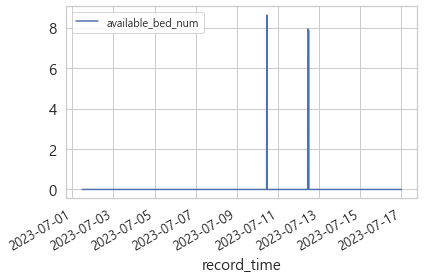

In [1280]:
dflist['의료법인동해동인병원'].plot()

의료법인동해동인병원 제거

In [1281]:
dflist = {'의료법인강릉동인병원':empty_emer1.copy(),
         '강원특별자치도강릉의료원':empty_emer2.copy(),
         '강릉아산병원':empty_emer3.copy(),
         '근로복지공단동해병원':empty_emer4.copy(),
         '강원특별자치도삼척의료원':empty_emer6.copy(),
         '강원특별자치도속초의료원':empty_emer7.copy()}

# df로 병원데이터 저장
for i in dflist:
    dflist[i] = dflist[i].drop('hospital_name',axis=1, inplace=False)
    dflist[i]['record_time']=pd.to_datetime(dflist[i]['record_time'], format = '%Y%m%d%H%M%S')
    dflist[i]=dflist[i].set_index('record_time')

In [1282]:
dflist['의료법인강릉동인병원'].index.is_unique

False

## 함수 정의


In [1283]:
# training 데이터의 samples 와 time steps로 원본데이터 슬라이싱 함수
def xysplit_data(train_data_scaled, test_data_scaled, 
                 train_data_len, test_data_len, time_steps, for_periods):
    x_train = [] 
    y_train = []  

    for i in range(time_steps, train_data_len):
        x_train.append(train_data_scaled[i-time_steps:i].copy())
        y_train.append(train_data_scaled[i:i+for_periods].values[0][0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # 3차원으로 재구성하기
    # x_train
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
    # X_test 
    inputs = pd.concat((train_data_scaled, test_data_scaled), axis=0).values
    inputs = inputs[len(inputs)-len(test_data_scaled) - time_steps:]
    inputs = inputs.reshape(-1,1)

    x_test = []
    for i in range(time_steps, test_data_len + time_steps):
        x_test.append(inputs[i-time_steps:i,0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
  
    return(x_train, y_train, x_test)

In [1284]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
    actual_pred['available_bed_num'] = test_data[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['available_bed_num']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot(figsize = (20, 5)))

In [1285]:
def confirm_result(y_test, y_pred):
#     MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
#     MSLE = mean_squared_log_error(y_test, y_pred)
#     RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[RMSE, R2],
                         index = ['RMSE', 'R2'],
                         columns=['Results'])
    return Result

In [1286]:
def result_GRU(GRU_prediction, train_GRU_prediction, test_data):
    actual_pred_plot(GRU_prediction)

    # 예측 성능 지표로 GRU 수행 결과 확인하기
    y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
    y_test_gru=test_data[0:len(GRU_prediction)]
    y_test_gru.reset_index(drop=True, inplace=True)
    test_result = confirm_result(y_test_gru, y_pred_gru)

    train_pred_gru = pd.DataFrame(train_GRU_prediction[:, 0])
    y_train_gru=train_data[time_steps:]
    y_train_gru.reset_index(drop=True, inplace=True)
    train_result = confirm_result(y_train_gru, train_pred_gru)

    test_result.columns = ['test result']
    train_result.columns = ['train result']
    total_result = pd.concat([test_result, train_result], axis = 1)
    print(total_result)

# 1. 의료법인강릉동인병원

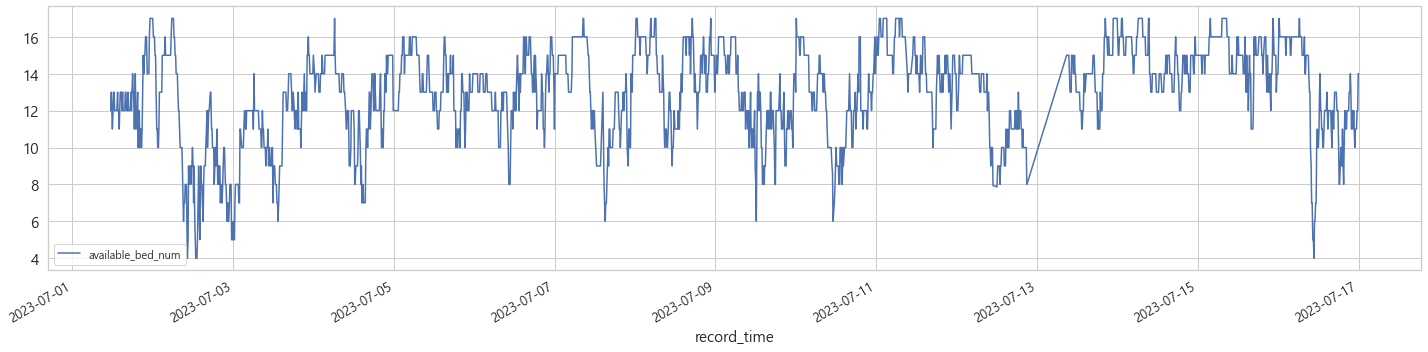

In [1287]:
df = dflist['의료법인강릉동인병원'].plot(figsize = (20, 5))

데이터 결함으로 중간부분 12시간 빠짐

2023-07-12 20:51:30 ~ 2023-07-13 08:50:09

<AxesSubplot:xlabel='record_time'>

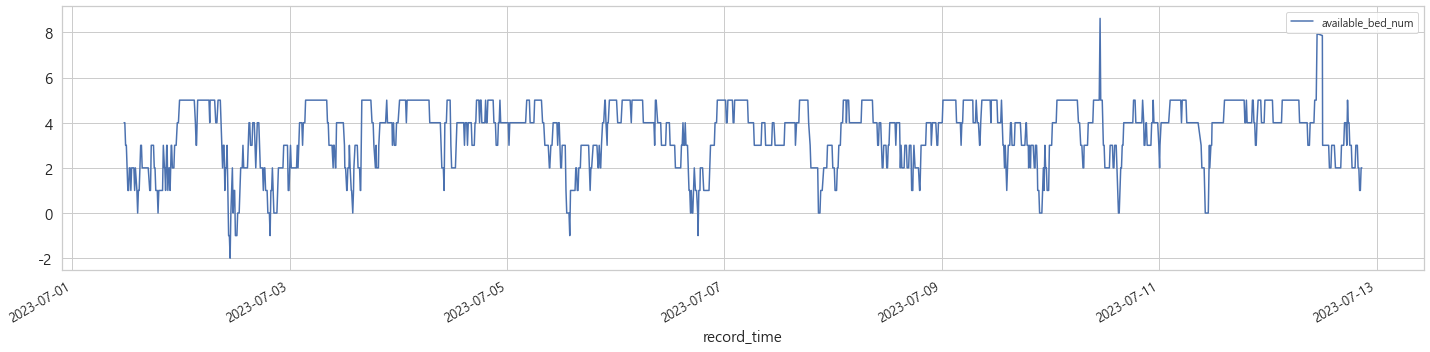

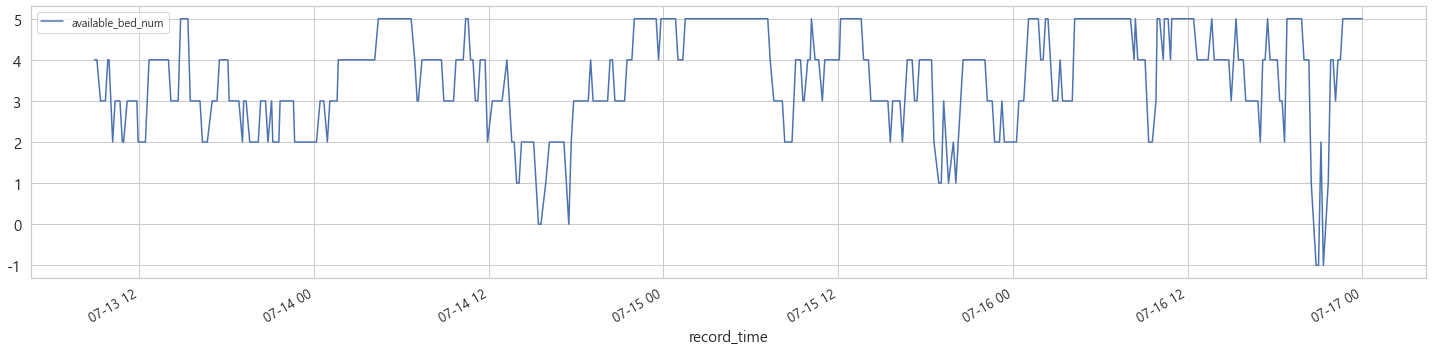

In [1288]:
# 절단 기점으로 trqin test 분리
data.loc[:'2023-07-12 20:51:30'].plot(figsize = (20, 5))
data.loc['2023-07-13 08:50:09':].plot(figsize = (20, 5))

In [1289]:
# 중복값 제거
df = data.loc[:'2023-07-12 20:51:30'].copy()
df = df.loc[~df.index.duplicated(keep='first')]
print(df.index.is_unique)
train_data = df

df = data.loc['2023-07-13 08:50:09':].copy()
df = df.loc[~df.index.duplicated(keep='first')]
print(df.index.is_unique)
test_data = df

True
True


<AxesSubplot:xlabel='record_time'>

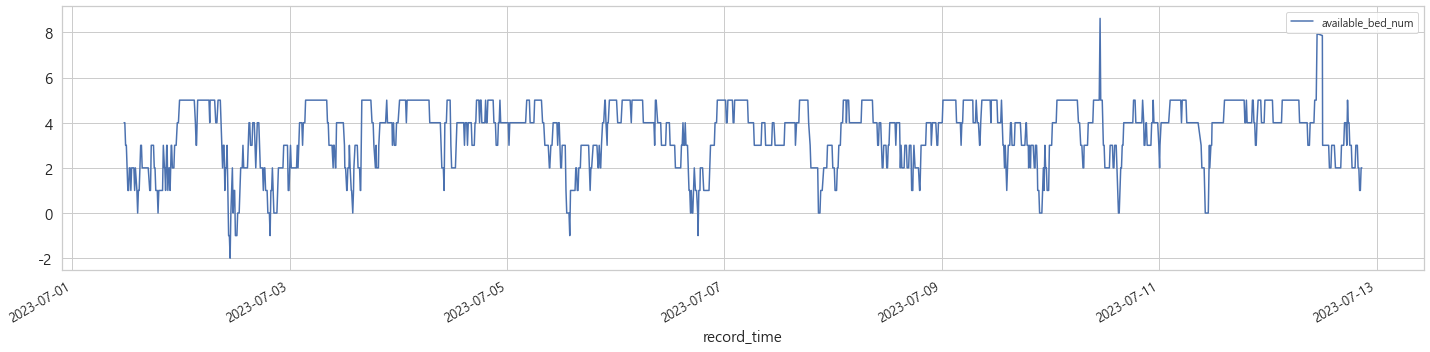

In [1290]:
train_data.plot(figsize = (20, 5))

<AxesSubplot:xlabel='record_time'>

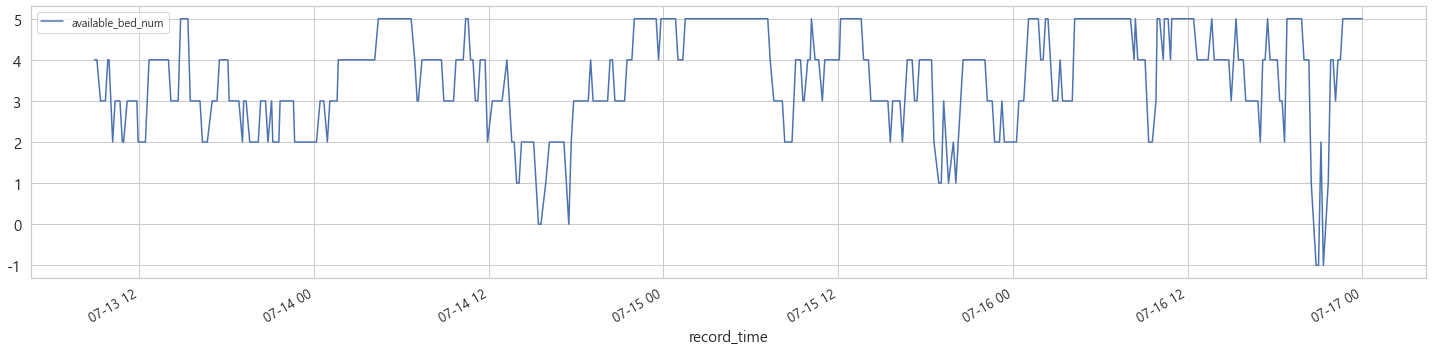

In [1291]:
test_data.plot(figsize = (20, 5))

In [1292]:
train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1592, 1)
test shape ::  (507, 1)


In [1293]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1294]:
time_steps=30
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [1295]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(1562, 30, 1)

In [1296]:
x_test.shape

(507, 30, 1)

GRU 모델 만들기

In [1297]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh', ))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 100, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

49/49 [==============================] - 0s 7ms/step


,test result,train result
RMSE,0.64353,0.59397
R2,0.72354,0.81665


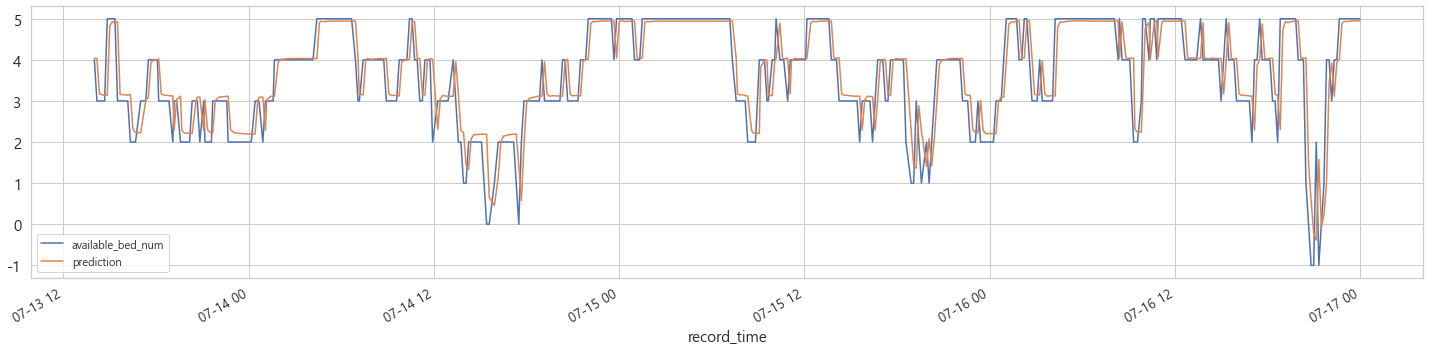

In [1298]:
# 중간에 절단되었으므로 앞 time_steps만큼의 예측값 버리기

preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[time_steps:len(preds)]
actual_pred['prediction'] = preds[time_steps:,0]

from keras.metrics import MeanSquaredError 
m = MeanSquaredError()
m.update_state(np.array(actual_pred['available_bed_num']), np.array(actual_pred['prediction']))

actual_pred.plot(figsize = (20, 5))

# 예측 성능 지표로 GRU 수행 결과 확인하기
y_pred_gru = pd.DataFrame(GRU_prediction[time_steps:, 0])
y_test_gru=test_data[time_steps:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)
test_result = confirm_result(y_test_gru, y_pred_gru)

train_pred_gru = pd.DataFrame(train_GRU_prediction[:, 0])
y_train_gru=train_data[time_steps:]
y_train_gru.reset_index(drop=True, inplace=True)
train_result = confirm_result(y_train_gru, train_pred_gru)

test_result.columns = ['test result']
train_result.columns = ['train result']
total_result = pd.concat([test_result, train_result], axis = 1)
total_result

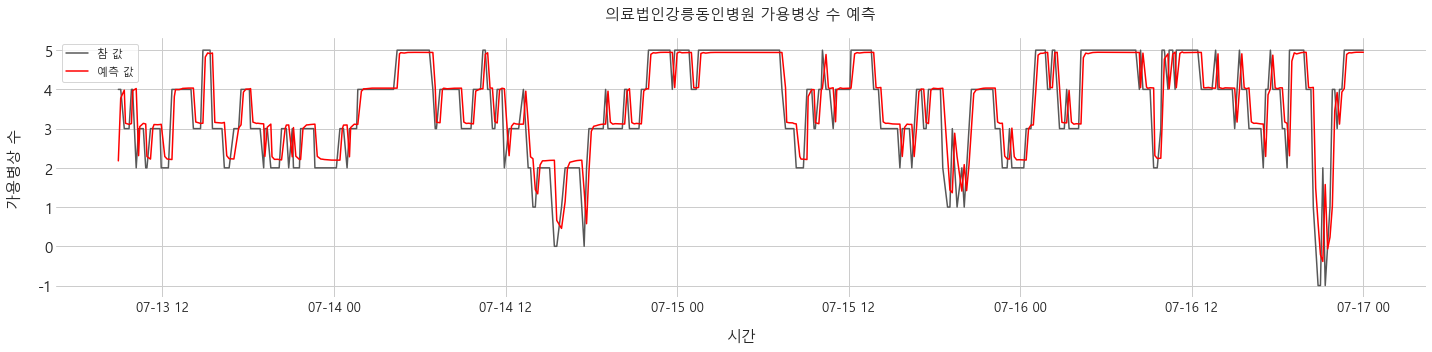

In [1299]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('의료법인강릉동인병원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/의료법인강릉동인병원_predict.png', bbox_inches="tight")
plt.show()

# 2. 강원특별자치도강릉의료원

<AxesSubplot:xlabel='record_time'>

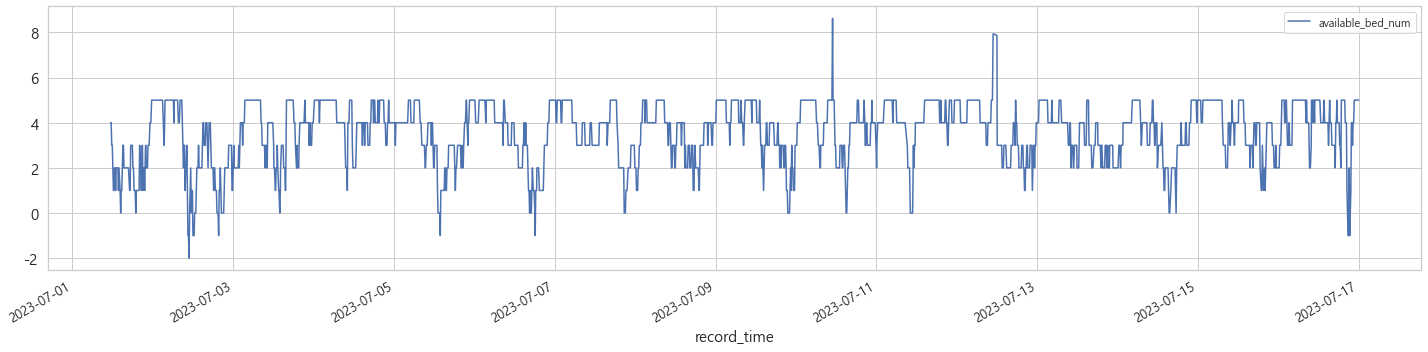

In [1300]:
data = dflist['강원특별자치도강릉의료원'].copy()
data.plot(figsize = (20, 5))

In [1301]:
data = data.loc[~data.index.duplicated(keep='first')]
data.index.is_unique

True

In [1302]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)].copy()
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1736, 1)
test shape ::  (433, 1)


In [1303]:
train_data.index.is_unique

True

Text(0.5, 1.0, '강원특별자치도강릉의료원')

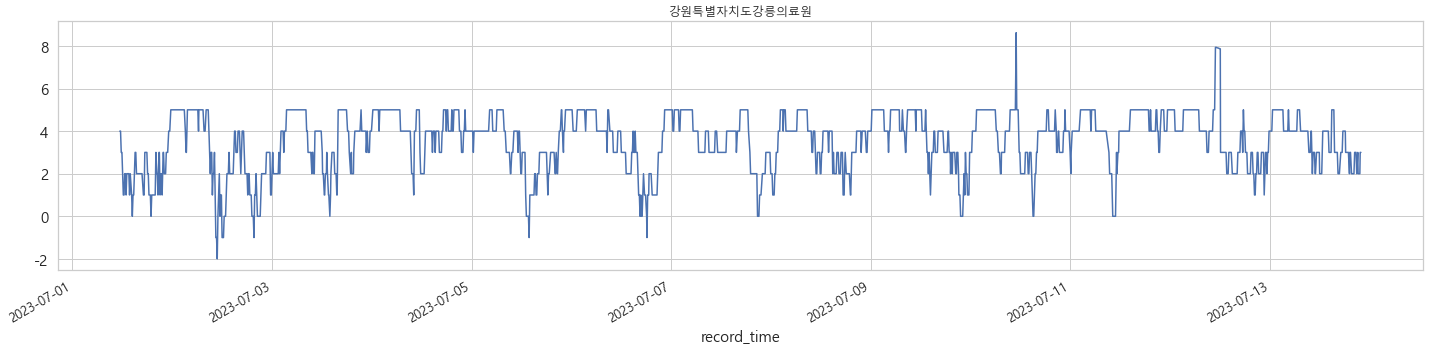

In [1304]:
train_data['available_bed_num'].plot(figsize = (20, 5))
plt.title('강원특별자치도강릉의료원')

Text(0.5, 1.0, '강원특별자치도강릉의료원')

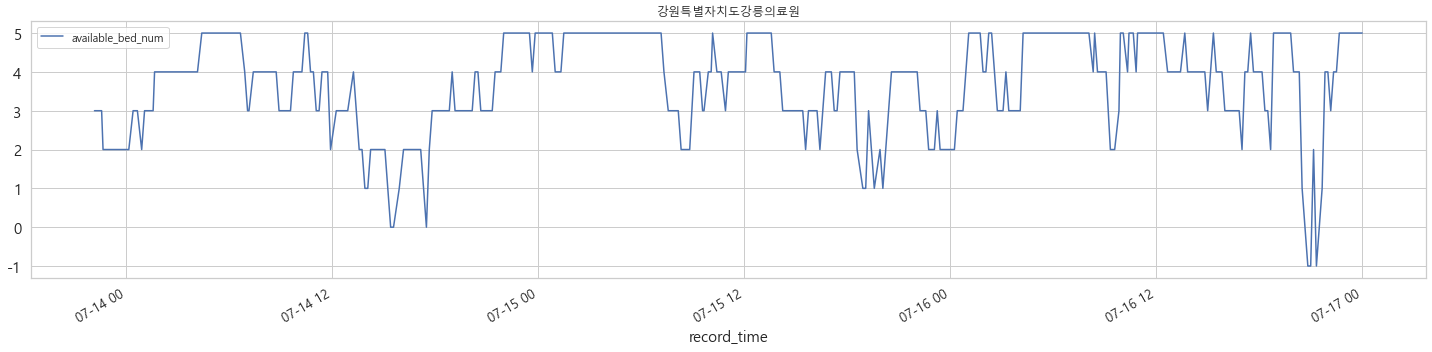

In [1305]:
test_data.plot(figsize = (20, 5))
plt.title('강원특별자치도강릉의료원')

In [1306]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1307]:
time_steps= 20
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [1308]:
print('x_train.shape:', x_train.shape ,'\nx_test.shape:', x_test.shape)

x_train.shape: (1716, 20, 1) 
x_test.shape: (433, 20, 1)


GRU 모델 만들기

In [1309]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 30, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'relu'))
my_GRU_model.add(GRU(units = 30, 
                     activation = 'relu'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 30, batch_size = 30, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

54/54 [==============================] - 0s 7ms/step


      test result  train result
RMSE      0.63712       0.58616
R2        0.73372       0.81412


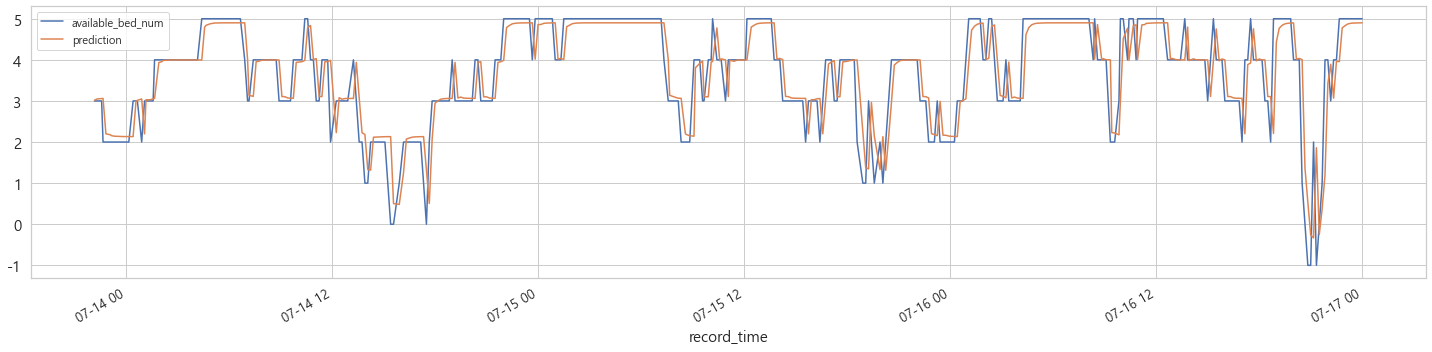

In [1310]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

In [1311]:
# import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")

!python han-font.py
exec(open('han-font.py').read())


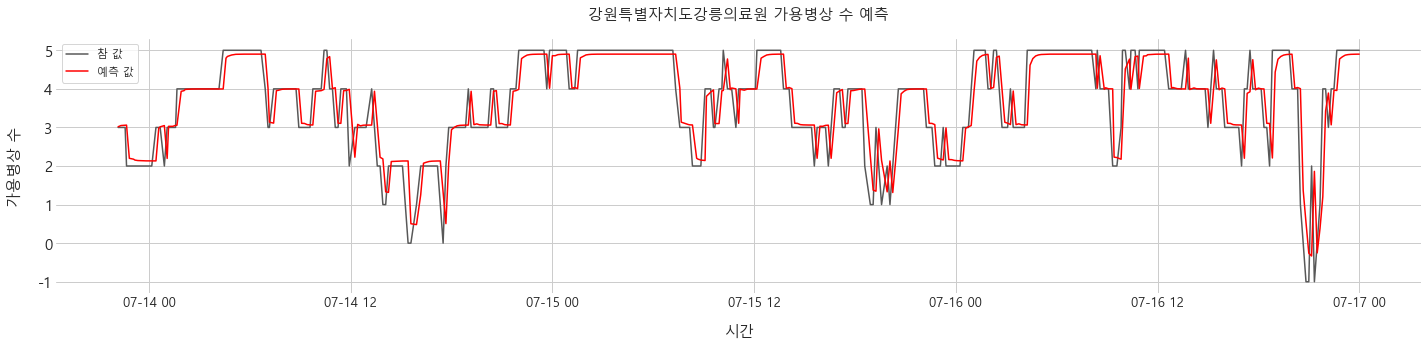

In [1312]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('강원특별자치도강릉의료원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/강원특별자치도강릉의료원_predict.png', bbox_inches="tight")
plt.show()

# 3. 강릉아산병원

In [1313]:
dflist['강릉아산병원'].head()

,available_bed_num
record_time,
2023-07-01 11:26:05,9.00000
2023-07-01 11:29:05,9.00000
2023-07-01 11:29:05,9.00000
2023-07-01 11:29:05,9.00000
2023-07-01 11:29:05,9.00000


In [1314]:
data = dflist['강릉아산병원'].copy()

Text(0.5, 1.0, '강릉아산병원')

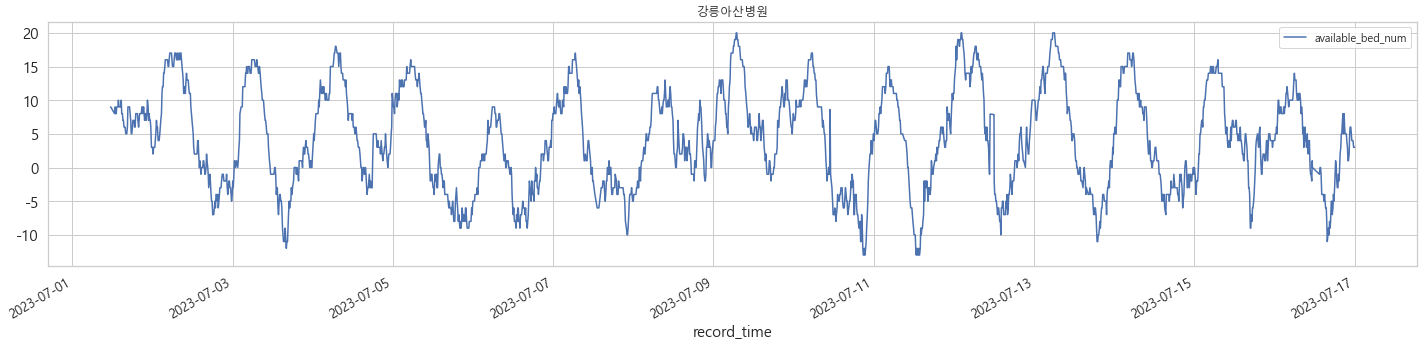

In [1315]:
data.plot(figsize = (20, 5))
plt.title('강릉아산병원')

In [1316]:
data.index.is_unique

False

In [1317]:
data = data.loc[~data.index.duplicated(keep='first')]
data.index.is_unique

True

In [1318]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1716, 1)
test shape ::  (428, 1)


In [1319]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1320]:
time_steps=20
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [1321]:
print('x_train.shape:', x_train.shape ,'\nx_test.shape:', x_test.shape)

x_train.shape: (1696, 20, 1) 
x_test.shape: (428, 20, 1)


GRU 모델 만들기

In [1322]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 50, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 50, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 30, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

53/53 [==============================] - 0s 8ms/step


      test result  train result
RMSE      1.36932       1.29915
R2        0.95589       0.97111


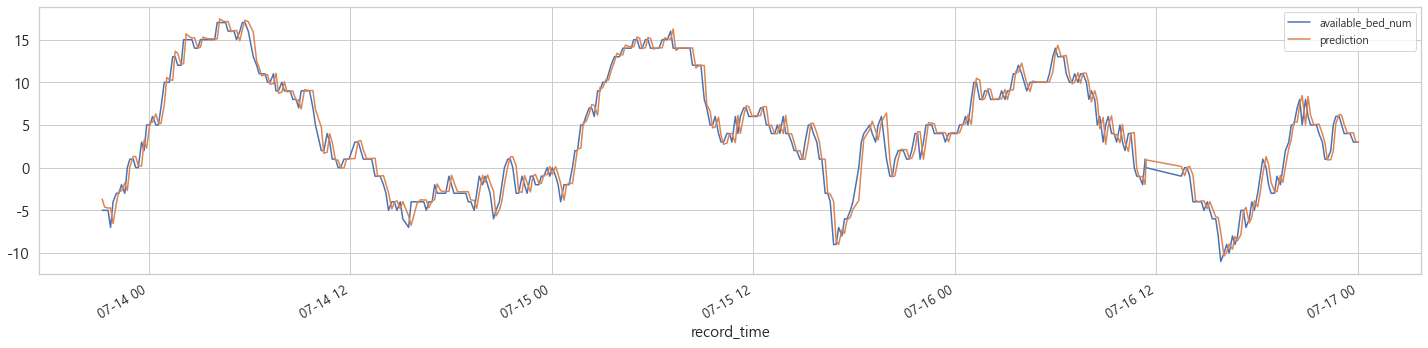

In [1323]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

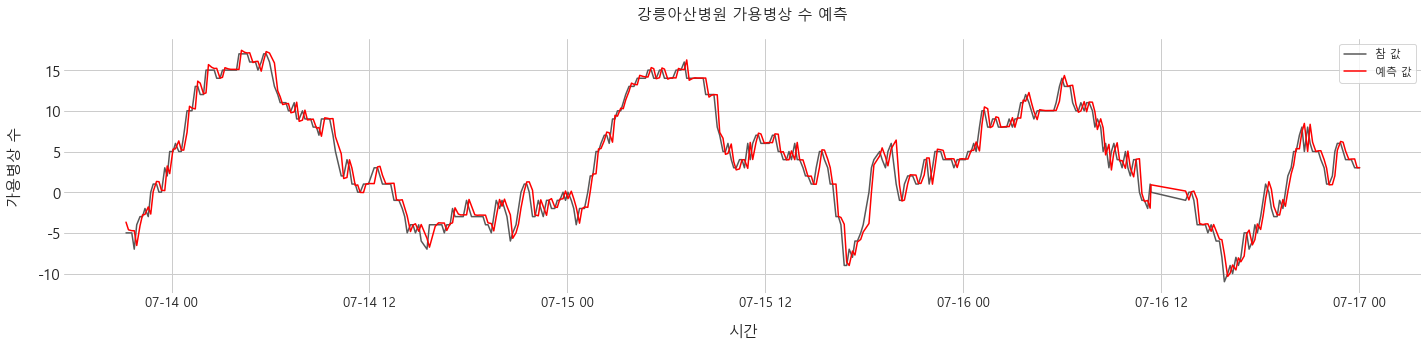

In [1324]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('강릉아산병원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/강릉아산병원_predict.png', bbox_inches="tight")
plt.show()

# 4. 근로복지공단동해병원

In [1325]:
dflist['근로복지공단동해병원'].head()

,available_bed_num
record_time,
2023-07-01 11:23:00,5.00000
2023-07-01 11:35:00,5.00000
2023-07-01 11:44:00,5.00000
2023-07-01 11:53:00,6.00000
2023-07-01 12:05:00,6.00000


In [1326]:
data = dflist['근로복지공단동해병원'].copy()

In [1327]:
data.index.is_unique

False

In [1328]:
data = data.loc[~data.index.duplicated(keep='first')]
data.index.is_unique

True

Text(0.5, 1.0, '근로복지공단동해병원')

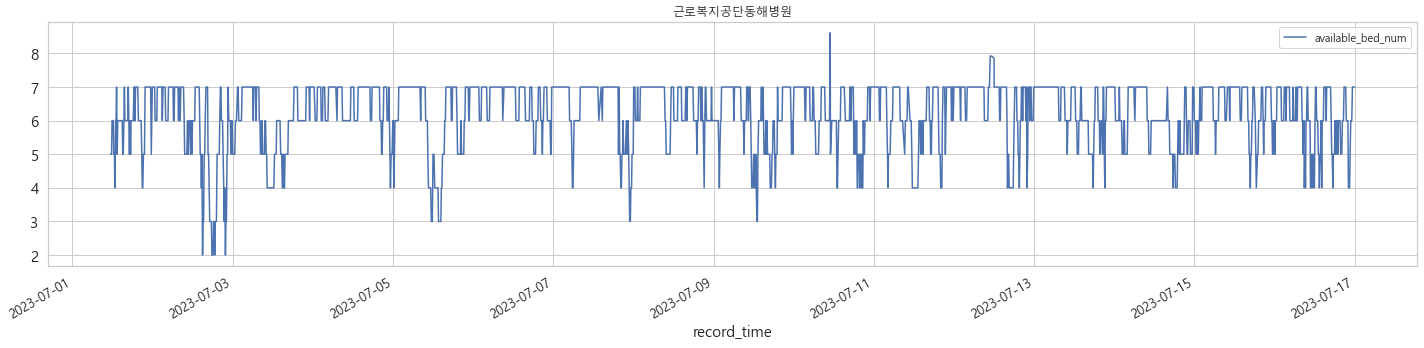

In [1329]:
data.plot(figsize = (20, 5))
plt.title('근로복지공단동해병원')

In [1330]:
# data split
split_rate = 0.7

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1517, 1)
test shape ::  (650, 1)


In [1331]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1332]:
time_steps=12
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [1333]:
print('x_train.shape:', x_train.shape ,'\nx_test.shape:', x_test.shape)

x_train.shape: (1505, 12, 1) 
x_test.shape: (650, 12, 1)


GRU 모델 만들기

In [1334]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 30, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'relu'))
my_GRU_model.add(GRU(units = 30, 
                     activation = 'relu'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 100, batch_size = 100, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

48/48 [==============================] - 0s 4ms/step


      test result  train result
RMSE      0.56136       0.52770
R2        0.60327       0.72734


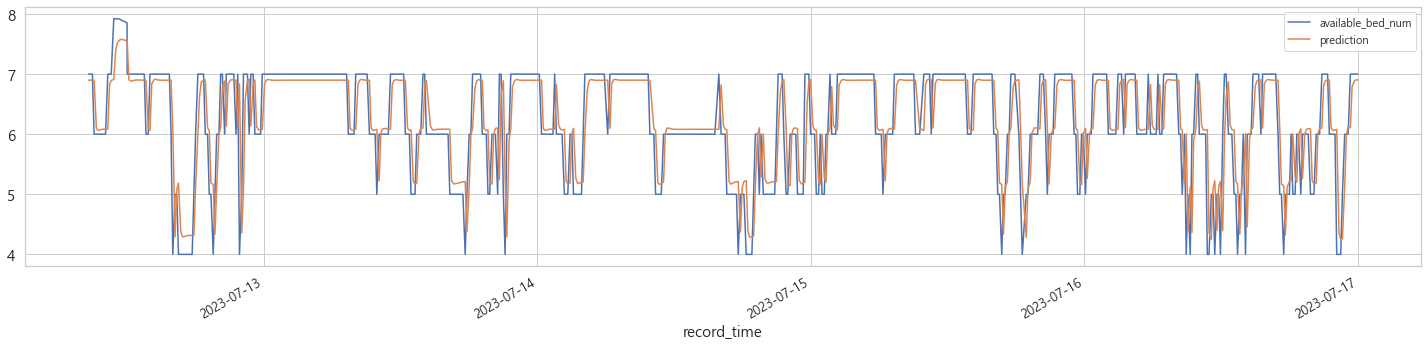

In [1335]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

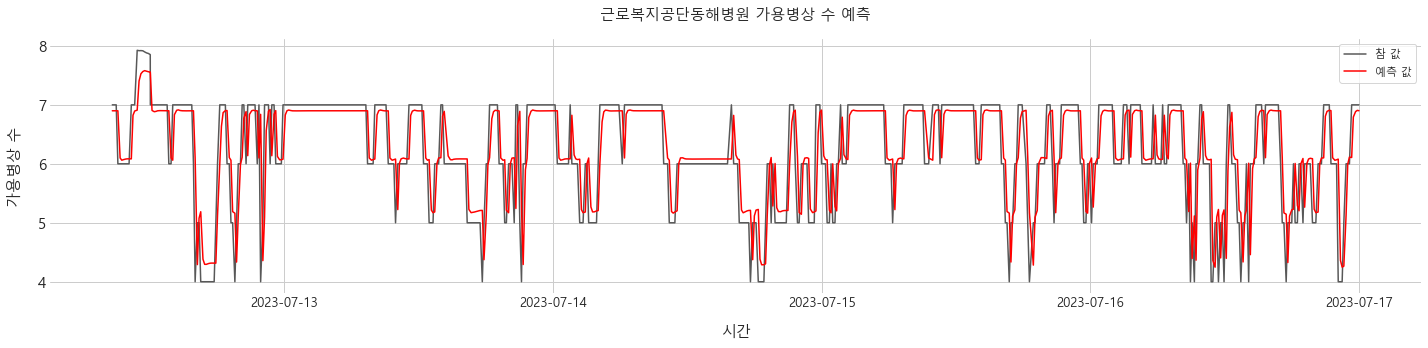

In [1336]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('근로복지공단동해병원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/근로복지공단동해병원_predict.png', bbox_inches="tight")
plt.show()

# 5. 강원특별자치도삼척의료원

In [1337]:
dflist['강원특별자치도삼척의료원'].head()

,available_bed_num
record_time,
2023-07-01 11:25:01,13.00000
2023-07-01 11:35:02,13.00000
2023-07-01 11:45:02,12.00000
2023-07-01 11:55:01,11.00000
2023-07-01 12:05:01,11.00000


In [1338]:
data = dflist['강원특별자치도삼척의료원'].copy()

In [1339]:
data.index.is_unique

False

In [1340]:
data = data.loc[~data.index.duplicated(keep='first')]
data.index.is_unique

True

Text(0.5, 1.0, '강원특별자치도삼척의료원')

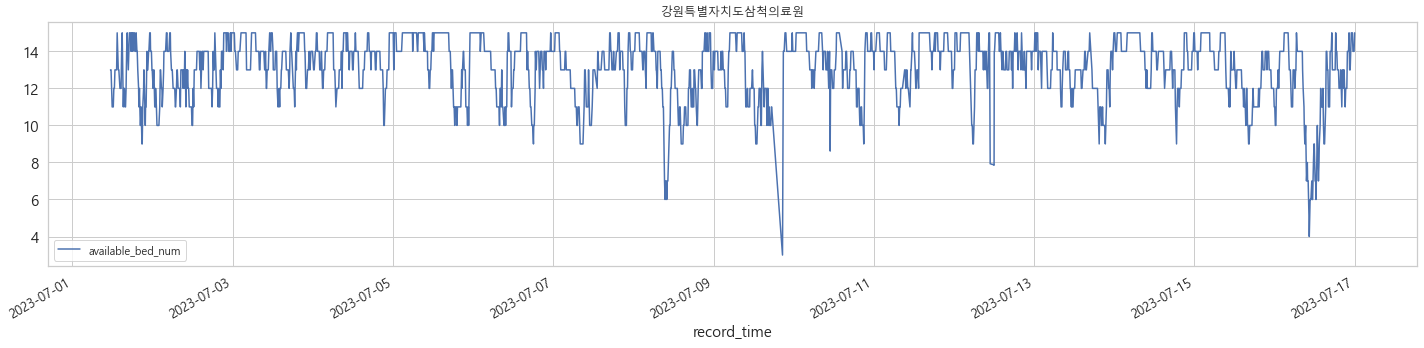

In [1341]:
data.plot(figsize = (20, 5))
plt.title('강원특별자치도삼척의료원')

In [1342]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1717, 1)
test shape ::  (429, 1)


In [1343]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1344]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [1345]:
print('x_train.shape:', x_train.shape ,'\nx_test.shape:', x_test.shape)

x_train.shape: (1711, 6, 1) 
x_test.shape: (429, 6, 1)


GRU 모델 만들기

In [1346]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 30, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 30, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 20, batch_size = 10, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

54/54 [==============================] - 0s 4ms/step


      test result  train result
RMSE      0.78247       0.83615
R2        0.84956       0.72860


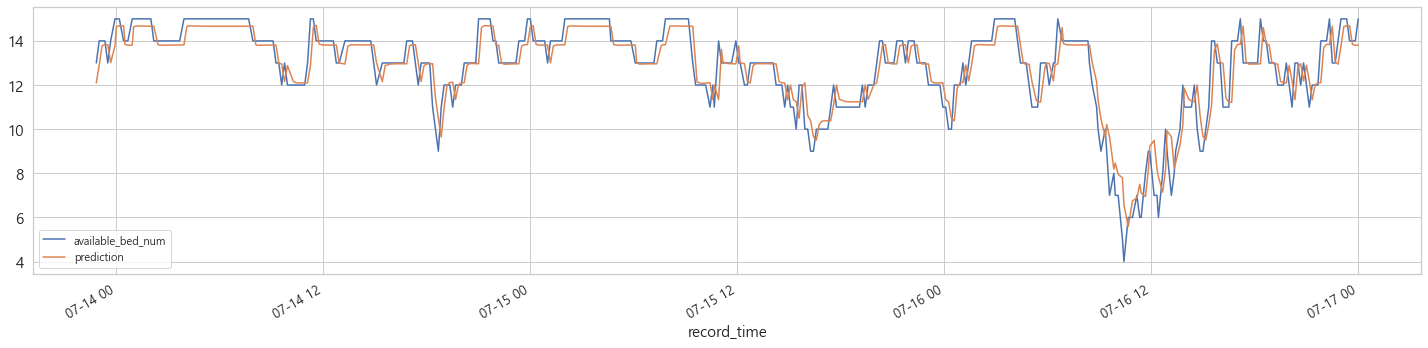

In [1347]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

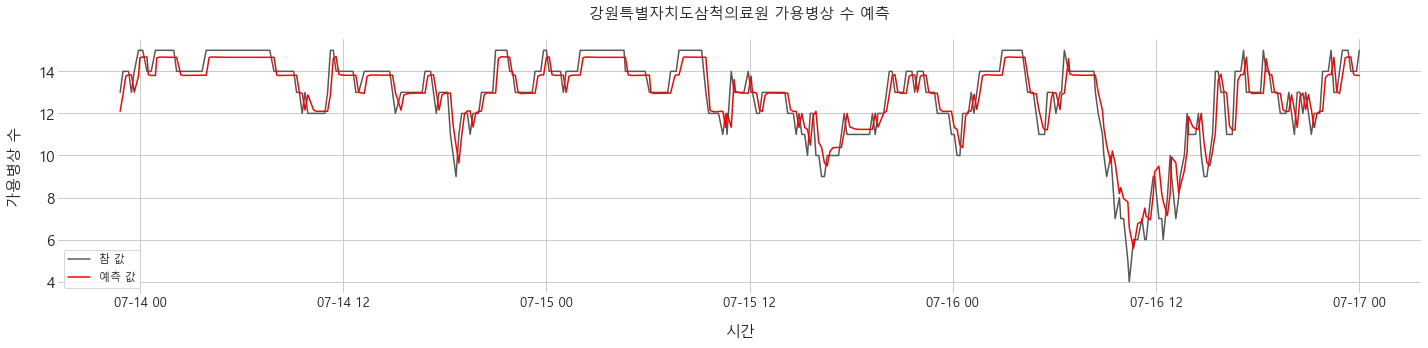

In [1348]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('강원특별자치도삼척의료원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/강원특별자치도삼척의료원_predict.png', bbox_inches="tight")
plt.show()

# 6. 강원특별자치도속초의료원

In [1349]:
dflist['강원특별자치도속초의료원'].head()

,available_bed_num
record_time,
2023-07-01 11:25:01,16.00000
2023-07-01 11:35:01,17.00000
2023-07-01 11:45:01,16.00000
2023-07-01 11:55:01,15.00000
2023-07-01 12:05:01,12.00000


In [1350]:
data = dflist['강원특별자치도속초의료원'].copy()

In [1351]:
data.index.is_unique

False

In [1352]:
data = data.loc[~data.index.duplicated(keep='first')]
data.index.is_unique

True

Text(0.5, 1.0, '강원특별자치도삼척의료원')

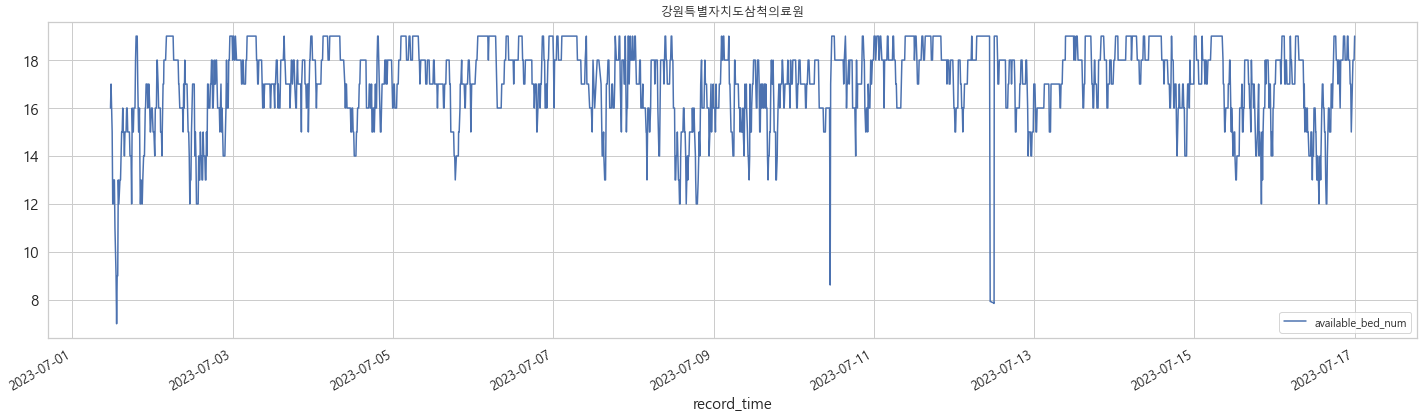

In [1353]:
data.plot(figsize = (20, 6))
plt.title('강원특별자치도삼척의료원')

In [1354]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (1736, 1)
test shape ::  (433, 1)


In [1355]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [1356]:
time_steps=18
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)
print('x_train.shape:', x_train.shape ,'\nx_test.shape:', x_test.shape)

x_train.shape: (1718, 18, 1) 
x_test.shape: (433, 18, 1)


GRU 모델 만들기

In [1357]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 100, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 100, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 60, batch_size = 150, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

54/54 [==============================] - 1s 14ms/step


      test result  train result
RMSE      0.79534       0.87087
R2        0.77316       0.72556


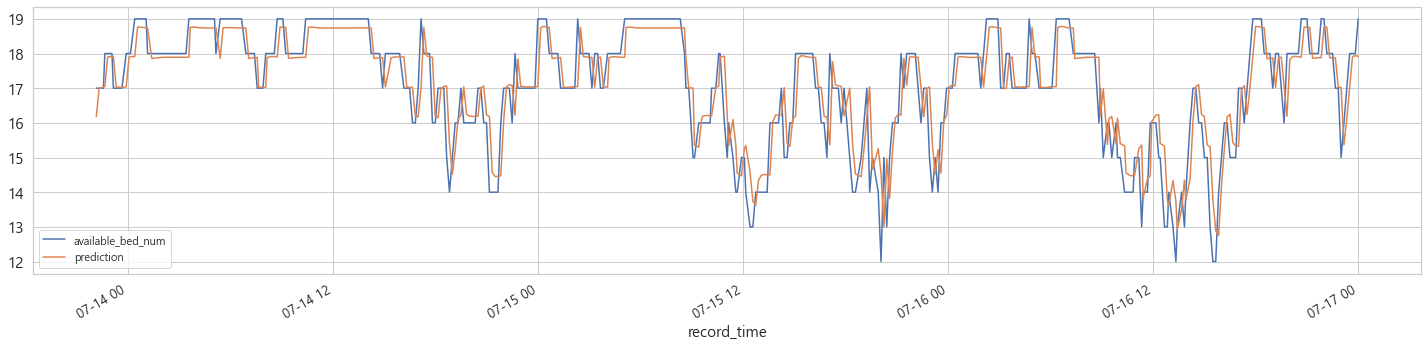

In [1358]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

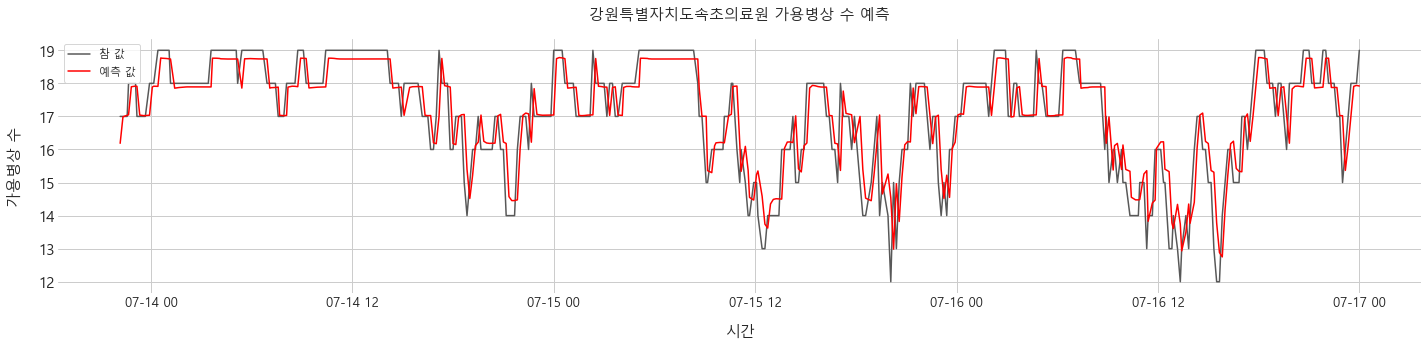

In [1359]:
preds = GRU_prediction
actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
actual_pred['available_bed_num'] = test_data[0:len(preds)]
actual_pred['prediction'] = preds[:,0]

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize = (20, 5))   ## 캔버스 생성
ax = fig.add_subplot()                ## 그림 뼈대(프레임) 생성
ax.plot(actual_pred['available_bed_num'], color = '#585858', label='참 값')
ax.plot(actual_pred['prediction'], color='#FF0000', label='예측 값')

plt.legend()
ax.tick_params(direction='in')

plt.xlabel('시간', labelpad=15)
plt.ylabel('가용병상 수', labelpad=15)
plt.title('강원특별자치도속초의료원 가용병상 수 예측', size = 15, pad=20)

sns.despine(left=True, bottom=True)

plt.rcParams.update({'figure.autolayout': True})
plt.savefig('../OUT/Inference/강원특별자치도속초의료원_predict.png', bbox_inches="tight")
plt.show()